![](https://i.imgur.com/KOjXRJg.jpg)

### <b><span style='color:#F1A424'>Test Classification</span></b>

- Text classification is one of the most common tasks in NLP
- It can be used for a wide range of applications (eg. tagging customer feedback into categories, routing support tickets according to their language)
- Another common type of text classification problem is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">sentiment analysis</mark>** which aims to **identify the polatity** of a given text (+/-)

### <b><span style='color:#F1A424'>Our Task</span></b>

- We need to build a system that will be able to automatically identify emotional states (eg. anger, joy) that people express about your company's product on twitter
- For this task, we'll be using a variant of **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">BERT</mark>**; **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>**, the main advantage of this model is that it is much smaller than **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">BERT</mark>** (ie. more efficient), but is able to achieve comparable performance
- We will be using three core libraries from the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Hugging Face</mark>** ecosystem: **<span style='color:#FFC300'>Datasets</span>**, **<span style='color:#FFC300'>Tokenizers</span>** & **<span style='color:#FFC300'>Transformers</span>**

In [1]:
!pip install datasets --upgrade
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>1 |</span></b> <b>THE DATASET</b></div>
    
- Many data sets involving **sentiment** analysis are **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">binary</mark>** classification problems
- In this dataset we have **6 different sentiments**, which means we'll be treating this problem as a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">multiclass</mark>** classification problem

In [2]:
!ls data/

test.csv  training.csv	validation.csv


In [3]:
import pandas as pd
import numpy as np
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20),
                    show_index=False,
                    pagination='local',
                         page_size=10)


pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

validation = pd.read_csv('data/validation.csv')
train = pd.read_csv('data/training.csv')
test = pd.read_csv('data/test.csv')

print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [4]:
show_panel(train)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

### <b><span style='color:#F1A424'>Combine DataFrames into Dataset</span></b>
- It can be more intuitive to utilise **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">HuggingFace</mark>**'s Dataset  

In [5]:
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

# Don't forget the class label data
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets
emotions = DatasetDict({
    "train": Dataset.from_pandas(train,features=ft),
    "test": Dataset.from_pandas(test,features=ft),
    "validation": Dataset.from_pandas(validation,features=ft)
    })

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)

emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### <b><span style='color:#F1A424'>Selecting a Subset</span></b>
- We'll be working with the **training and validation dataset** in this problem
- Lets just show some useful fearures of the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Dataset</mark>** class

In [6]:
# Training Data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
# Get First 5 Entries in Dictionary Format (Group them)
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### <b><span style='color:#F1A424'>Dataset to DataFrame Convertion</span></b>
- Whenever we need a pandas `DataFrame`, eg. for visualisations, we can utlise the `Dataset`'' method `.set_format`

In [8]:
# Convert Dataset to DataFrame (don't forget to reset)
emotions.set_format(type="pandas")
df = emotions["train"][:]
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

### <b><span style='color:#F1A424'>Adding Label Data</span></b>
- We made sure to not forget the `label_names` when converting from `DataFrame` to `Dataset`
- We can convert **numeric** values to **string** values by using method `int2str`

In [9]:
# Add label data to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>2 |</span></b> <b>CLASS DISTRIBUTION</b></div>

- Our dataset has 6 classes `joy`, `sadness`, `anger`, `fear`, `love` and `surprise`; multiclass problem

In [10]:
import plotly.express as px

px.bar(df['label_name'].value_counts(ascending=True),template='plotly_white')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b>LENGTH OF EACH TWEET</b></div>

- For applications using **DistilBERT**, the maximum context size is **512 tokens**
- Most tweets are around **10-20 words** long, which falls well within this limit

In [11]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

px.box(df,y='Words Per Tweet',
       color='label_name',
       template='plotly_white')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>TOKENISATION</b></div>

- As with other models, **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** cannot receive raw python strings as input
- Instead we need to break down the strings into subgroups called **tokens** and encode them as **numerical vectors**
- Let's consider two types of **tokenisation** approaches: **<span style='color:#FFC300'>character</span>** & **<span style='color:#FFC300'>word</span>** tokenisation

### <b><span style='color:#F1A424'> 4.1 | </span>Character tokenisation </b>

The simplest tokenisation approach is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">character tokenisation</mark>**, we can use python's inbuilt **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">list</mark>** class

In [12]:
text = 'Tokenisation of text is a core task of NLP.'
tokenised_text = list(text)

# Character Tokenised list
print(f'Number of tokens: {len(tokenised_text)}')
print(tokenised_text)

Number of tokens: 43
['T', 'o', 'k', 'e', 'n', 'i', 's', 'a', 't', 'i', 'o', 'n', ' ', 'o', 'f', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


- Convert each character into an integer (numericalisation)
- `token2idx` gives us a mapping from each character in the **vocabulary** to a unique integer

In [13]:
# Mapping Vocabulary dictionary
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenised_text)))}

print(f'Length of vocabulary: {len(token2idx)}')
print(token2idx)

Length of vocabulary: 18
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17}


### <b><span style='color:#F1A424'>Reconstructing text</span></b>
- Once we have a vocabulary dictionary, we can reconstruct the

In [14]:
# Let's represent text in numerical format
input_ids = [token2idx[token] for token in tokenised_text]

print(f'{len(input_ids)} characters')
print(input_ids)

43 characters
[5, 13, 11, 8, 12, 10, 15, 6, 16, 10, 13, 12, 0, 13, 9, 0, 16, 8, 17, 16, 0, 10, 15, 0, 6, 0, 7, 13, 14, 8, 0, 16, 6, 15, 11, 0, 13, 9, 0, 3, 2, 4, 1]


### <b><span style='color:#F1A424'>Convert to OHE</span></b>

- Last step is to convert `input_ids` to a 2D tensor of one-hot vectors, let's use pytorch below
- One-Hot vectors are frequently used in ML applications to encode **categorical data** (either ordinal or nominal)
- For each of the 42 input token, we now have a one-hot vector with 18 dimensions (vocab size)

In [15]:
import torch
import torch.nn.functional as F

inputs_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(inputs_ids,num_classes = len(token2idx))
print(f'OHE size: {one_hot_encodings.shape}')

OHE size: torch.Size([43, 18])


### <b><span style='color:#F1A424'>Drawbacks of Character Tokenisation</span></b>

- Character level tokenisation ignores any structure in the text & treats the whole string as a stream of characters
- This helps deal with missspellings and rear words, but the main drawback is that linguistic structures need to be learned from the data
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Character tokenisation</mark>** is rarely used in practice, instead **some structure of the text is preserved** if we utilise **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Word Tokenisation</mark>**

### <b><span style='color:#F1A424'> 4.2 | </span>Word tokenisation </b>

- Instead of splitting the text into characters, we can split **it into words** & **map each word to an integer**
- The simplest form of tokenisation is if we utilise python's inbuilt **string** class `split` method
- Unlike **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Character tokenisation</mark>**, if we have declinations, conjugations, misspellings, the size of the **vocabulary dictionary** can grow very rapidly
- Larger **vocabularies** are a problem, because it requires the model to have an excess of parameters (which is inefficient)


- It's common to select the **<span style='color:#FFC300'>most common 100,000 words</span>** in the **corpus**
- words that are not part of the vocabulary are classified as unknown and mapped to a shared **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">UNK</mark>** token
- However, can potentially lose some important information during the process of tokenisation, since the model has no information about words associated with **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">UNK</mark>**

In [16]:
tokenised_text = text.split()
print(tokenised_text)

['Tokenisation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### <b><span style='color:#F1A424'> 4.3 | </span>Subword tokenisation </b>

- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** is to combine the best aspects of **<span style='color:#FFC300'>character</span>** & **<span style='color:#FFC300'>word</span>** tokenisation
- The main distinguishing feature of **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** is that it is learned from a **pretraining corpus** using a mix of statistical rules and algorithms


- There are several **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** algorithms that are commonly used in NLP
    - let’s start with `WordPiece`, which is used by the `BERT` and `DistilBERT` tokenizers
    

- `AutoTokenizer` class allows us to quickly load te tokeniser associated with a pretrained model
- Or we can load the Tokeniser manually from `transformers.DistilBertTokenizer`



In [17]:
from transformers import AutoTokenizer

text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Show tokeniser information
tokenizer

# Or we can load the Tokeniser manually `transformers.DistilBertTokenizer`

# from transformers import DistilBertTokenizer

# model_ckpt = "distilbert-base-uncased"
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
# distilbert_tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [18]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')


Vocab size: 30522
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


In [19]:
print('Encoded text')
encoded_text = tokenizer(text)
print(encoded_text,'\n')

print('Tokens')
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens,'\n')

print('Convert tokens to string')
print(tokenizer.convert_tokens_to_string(tokens),'\n')

Encoded text
{'input_ids': [101, 19204, 6648, 1997, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

Tokens
['[CLS]', 'token', '##isation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]'] 

Convert tokens to string
[CLS] tokenisation of text is a core task of nlp. [SEP] 



In [20]:
emotions.reset_format()

### <b><span style='color:#F1A424'> 4.4 | </span>Tokenising the entire dataset </b>

- When dealing with **text of different size**, the tokeniser will **<span style='color:#FFC300'>pad</span>** sentences of insufficient length if **padding** is selected
- The **maximum length** of the tokenised data will be the **length of the longest tweet** (in example, 2nd row)
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Attention mask</mark>** helps the model understand which parts of the sentence to ignore

In [21]:
# Tokenisation function
def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Show the tokenised ids
ex_tokenised = tokenise(emotions["train"][:2])

In [22]:
emotions["train"][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0]}

In [23]:
# Show attention mask
ex_tokenised['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [24]:
# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>5 |</span></b> <b>TRAINING A TEXT CLASSIFIER</b></div>

- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** are pretrained to **predict masked words in a sentence of text**
- We **can't use these language models directly** for text classification, need some slight modification


- First the text is tokenised, represented using one-hot vectors called **token encodings**
- The size of the tokeniser vocabulary determines the dimension of the next encoding (usually 20-200k)
- Next these token encodings are converted to token embeddings (vectors living in a lower dimensional space)
- The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token
- For the pretrained objective of language modeling, each hidden state is fed to a layer that predicts the masked input tokens
- For the the **<span style='color:#FFC300'>classification task</span>**, we replace the **<span style='color:#FFC300'>language modeling layer</span>** with a **<span style='color:#FFC300'>classification layer</span>**

We have **<span style='color:#FFC300'>two options</span>** to train such a model on our dataset:
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Feature Extraction</mark>** : We use the hidden states as features, and just train the classifier on them, without modifying the pretrained model
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Fine Tuning</mark>** : We train the whole model, end-to-end, which subsequently also updates the parameters of the pretrained model


### <b><span style='color:#F1A424'> 5.1 | </span>Transformers as feature extractors </b>

### **<span style='color:#F1A424'>Using Pretrained Models</span>**

- We will use another auto class `AutoModel`, similar to `AutoTokenizer`
- `AutoModel` has method `from_pretrained` method to load weights of a pretrained model
- `AutoModel` class converts the token encodings to embeddings & feeds them through the encoder stack to return the **hidden states**

In [25]:
import warnings; warnings.filterwarnings('ignore')
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### **<span style='color:#F1A424'>Extracting the last hidden state (example)</span>**
Let's extract the last **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden state</mark>** for a single string
- First things first, let's encode the string and convert the tokens to Pytorch tensors
- Resulting tensor has shape **[batch_size,n_tokens]**
- Having encodings as tensors, the final step is to place them on the same device as the model & pass the inputs as follows

In [26]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


- Depending on the model configuration, the model can contain several objects (**<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Hidden states</mark>**, **losses**, **attentions**, ...)
- The current model (`distilbert-base-uncased`) returns only one attribute, which is the `last_hidden_state`

In [27]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [28]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


- The hidden state tensor (`last_hidden_state`) has the size: **[batch_size,n_tokens,hidden_dim]**
- ie. 768 dimensional vector is returned for each of the 6 input tokens


- For **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">classification tasks</mark>**
    - it is common practice to just use the **hidden state associated with the [CLS] token** as the input feature

In [29]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


### **<span style='color:#F1A424'>Extracting the last hidden state for the Dataset</span>**

- We know how to get the last hidden state for a single string, let's repeat the process for the entire dataset using `extract_hidden_states`

In [30]:
def extract_hidden_states(batch):

    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [31]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [32]:
# Extract last hidden states (faster w/ GPU)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### **<span style='color:#F1A424'>Creating the Feature Matrix</span>**

- We have **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** assciated with each tweet, now let's train the classifier
- To do that we need the feature matrix so we can utilise as input into the machine learning model

In [33]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(f'Training Dataset: {X_train.shape}')
print(f'Validation Dataset {X_valid.shape}')

Training Dataset: (16000, 768)
Validation Dataset (2000, 768)


In [34]:
# Let's check our dataset
X_train

array([[-0.1167513 ,  0.09857138, -0.12962897, ...,  0.0587108 ,
         0.35432693,  0.4042067 ],
       [-0.03236292, -0.03231524, -0.19572599, ..., -0.17465737,
         0.35463768,  0.30276582],
       [ 0.03974647,  0.2022336 ,  0.14227113, ..., -0.11406833,
         0.33937776,  0.395831  ],
       ...,
       [-0.00339847, -0.09585506,  0.05843544, ..., -0.04272703,
         0.2495916 ,  0.30761623],
       [ 0.06660261,  0.17334324,  0.12896673, ...,  0.06118569,
         0.29038215,  0.46844164],
       [ 0.01668789,  0.10127088, -0.00731721, ..., -0.06493651,
         0.34540522,  0.21993564]], dtype=float32)

### **<span style='color:#F1A424'>Visualising the Training Data</span>**

- We can visualise each class distribution the model will need to separate in **<span style='color:#FFC300'>lower dimension space</span>** (projections onto a lower-dimensional space)
- We have a lot of **categories overlapping** in lower dimensional space (doesn't mean the model won't be able to classify them in **<span style='color:#FFC300'>higher dimensional space</span>**)
- If they are separable in the projected space, they will probably be separable in **<span style='color:#FFC300'>higher dimensional space</span>**
- We'll utilise a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">manifold learning</mark>** unsupervised model **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">TSNE</mark>** (It will take a while)

In [35]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)

# lower dimension transformation
model = TSNE(n_components=2).fit(X_scaled)

# Create a df of 2D embeddings
df_embedding = pd.DataFrame(model.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_train

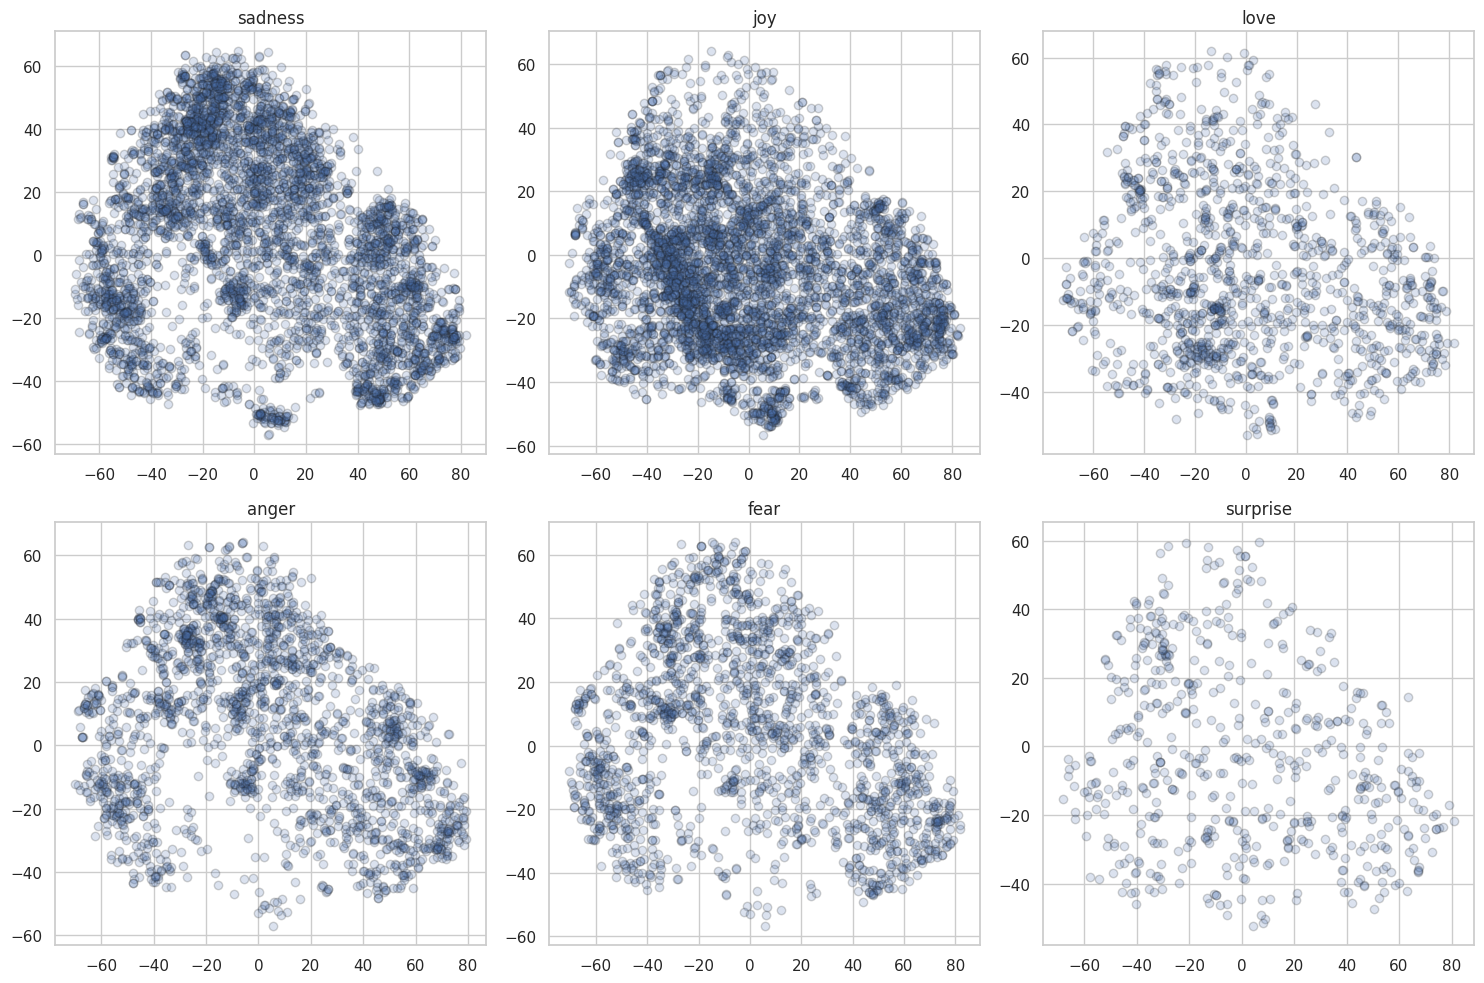

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
labels = emotions["train"].features["label"].names

for i, label in enumerate(labels):

    dict_embedding_sub = dict(tuple(df_embedding.groupby('label')))
    df_embedding_sub = dict_embedding_sub[i]

    axes[i].scatter(df_embedding_sub["X"],
                    df_embedding_sub["Y"],
                    lw=1,ec='k',alpha=0.2)

    axes[i].set_title(f'{label}')

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns:
- For **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">positive emotions</mark>** (**<span style='color:#FFC300'>joy</span>** and **<span style='color:#FFC300'>love</span>**) are well separated from the **<span style='color:#FFC300'>negative emotions</span>** and also share a similar space
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Negative emotions</mark>** (**<span style='color:#FFC300'>sadness</span>**, **<span style='color:#FFC300'>anger</span>**, and **<span style='color:#FFC300'>fear</span>**) all occupy very similar regions with slightly varying distributions in **<span style='color:#FFC300'>lower dimension space</span>**
- Finally, **<span style='color:#FFC300'>surprise</span>** is somewhat scattered all over the **<span style='color:#FFC300'>lower dimension space</span>**

### **<span style='color:#F1A424'>Training a Baseline Model</span>**

- Let's use these **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** to train a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model
- We're dealing with an unbalanced multiclass dataset, so our model may seem just better than random, but its actually better, let's compare to a `DummyClassifier`
- `DummyClassifier` can be used to build a classifier with simple heuristics (choosing the majority class/always drawing a random class),
- Let's choose most frequent (`strategy="most_frequent"`) so we have a reference model for comparison

In [37]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f'accuracy: {dummy_clf.score(X_valid, y_valid)}')

accuracy: 0.352


In [38]:
from sklearn.linear_model import LogisticRegression as LR

# We increase `max_iter` to guarantee convergence
lr_clf = LR(max_iter = 2000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.6335


### <b><span style='color:#F1A424'>Confusion Matrix</span></b>

- Our **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model with `DistilBERT` **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">embeddings</mark>** is signifcantly better than the baseline `DummyClassifier`
- Let check the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** of the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model

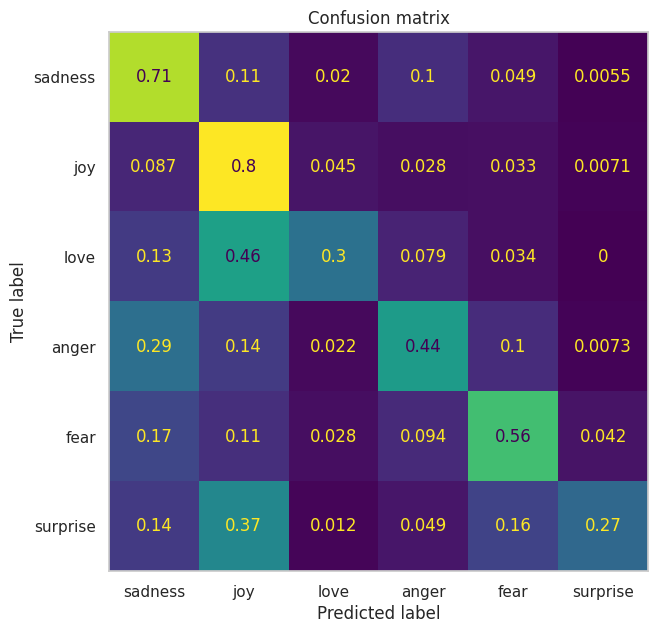

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels, )
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

From the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** we can say that:

- **<span style='color:#FFC300'>anger</span>**, **<span style='color:#FFC300'>fear</span>** & **<span style='color:#FFC300'>surprise</span>** often confused with **<span style='color:#FFC300'>sadness</span>** (0.29, 0.17 & 0.14) (observation we made when visualising the embeddings)
- **<span style='color:#FFC300'>love</span>** & **<span style='color:#FFC300'>surprise</span>** are frequently mistaken for **<span style='color:#FFC300'>joy</span>** (0.37 & 0.46)

### <b><span style='color:#F1A424'> 5.2 | </span>Fine-tuning transformers </b>

- With the fine-tune approach, we do not use the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** as fixed features, instead, we train them from a given model state
- This requires the classification head to be differentiable (neural network for classification)

### <b><span style='color:#F1A424'>Loading a Pretrained Model</span></b>

- We'll load the same **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model using `model_ckpt` **"distilbert-base-uncased"**
- This time however we will be loading `AutoModelForSequenceClassification` (we used `AutoModel` when we extracted embedding features)
- `AutoModelForSequenceClassification` model has a **<span style='color:#FFC300'>classification head</span>** on top of the pretrained model outputs
- We only need to specify the **<span style='color:#FFC300'>number of labels</span>** the model has to predict `num_labels`

In [40]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt,
                          num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### <b><span style='color:#F1A424'>Defining the Performance Metrics</span></b>
- We'll monitor the `F1 score`  & `accuracy`, the function is required to be passed in the `Trainer` class



In [41]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### <b><span style='color:#F1A424'>Training parameters</span></b>
- Next we need to define the model **training parameters**, which can be done using `TrainingArguments`
- Let's train the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model for **3 iterations** with a **learning rate of 2e-5** and a **batch size of 64**

In [42]:
from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(emotions_encoded["train"]) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

### <b><span style='color:#F1A424'>Train Model</span></b>
- With the training arguments set, we need to define the `Trainer` and start training with the `train()` method

In [43]:
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.782200,0.289365,0.907000,0.906418
2,0.213900,0.180280,0.928500,0.929415
3,0.147200,0.162077,0.929000,0.929227


TrainOutput(global_step=750, training_loss=0.38107977294921874, metrics={'train_runtime': 346.4222, 'train_samples_per_second': 138.559, 'train_steps_per_second': 2.165, 'total_flos': 1080514292544000.0, 'train_loss': 0.38107977294921874, 'epoch': 3.0})

In [44]:
# Predict on Validation Dataset
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output

PredictionOutput(predictions=array([[ 5.030549  , -1.1432055 , -0.8714728 , -1.1949254 , -1.3556654 ,
        -2.1221073 ],
       [ 4.9625297 , -1.2193558 , -1.4620215 , -1.0293725 , -0.7486905 ,
        -2.0457737 ],
       [-1.1436971 ,  2.2899053 ,  3.2878335 , -1.148424  , -2.3676507 ,
        -1.9184743 ],
       ...,
       [-1.7695754 ,  5.3044934 , -0.20905423, -1.4812745 , -2.0354922 ,
        -1.1715994 ],
       [-1.8249786 ,  3.3965614 ,  2.8166394 , -1.4643347 , -2.4456198 ,
        -1.5229403 ],
       [-1.8721031 ,  5.191802  , -0.6407359 , -1.7136838 , -1.8823032 ,
        -0.6033412 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.16207733750343323, 'test_accuracy': 0.929, 'test_f1': 0.9292272051010648, 'test_runtime': 3.8506, 'test_samples_per_second': 519.405, 'test_steps_per_second': 8.31})

In [45]:
print(f'Output Predition: {pred_output.predictions.shape}')
print(pred_output.predictions)

Output Predition: (2000, 6)
[[ 5.030549   -1.1432055  -0.8714728  -1.1949254  -1.3556654  -2.1221073 ]
 [ 4.9625297  -1.2193558  -1.4620215  -1.0293725  -0.7486905  -2.0457737 ]
 [-1.1436971   2.2899053   3.2878335  -1.148424   -2.3676507  -1.9184743 ]
 ...
 [-1.7695754   5.3044934  -0.20905423 -1.4812745  -2.0354922  -1.1715994 ]
 [-1.8249786   3.3965614   2.8166394  -1.4643347  -2.4456198  -1.5229403 ]
 [-1.8721031   5.191802   -0.6407359  -1.7136838  -1.8823032  -0.6033412 ]]


In [46]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions, axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

Output Prediction:(2000,)
Predictions: [0 0 2 ... 1 1 1]


In [47]:
# Show metrics of last iteration
pred_output.metrics

{'test_loss': 0.16207733750343323,
 'test_accuracy': 0.929,
 'test_f1': 0.9292272051010648,
 'test_runtime': 3.8506,
 'test_samples_per_second': 519.405,
 'test_steps_per_second': 8.31}

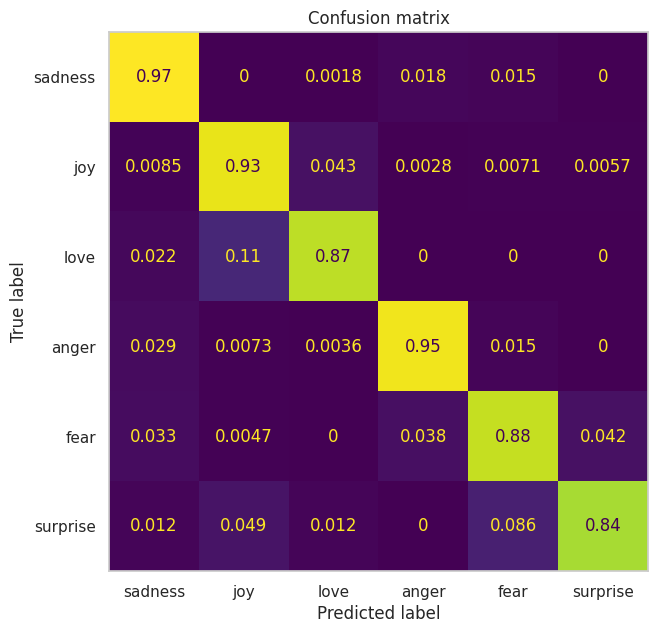

In [48]:
plot_confusion_matrix(y_preds,y_valid,labels)

From the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** we can say that:
- The **fine-tune** approach (using **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>**)  performs much better than simple extracting **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">embedding</mark>** data and training it on a separate ML model
- **<span style='color:#FFC300'>love</span>** is still often confused with **<span style='color:#FFC300'>joy</span>** (0.08), but much less than the first approach
- **<span style='color:#FFC300'>surprise</span>** is often confused with **<span style='color:#FFC300'>joy</span>** as well (0.09) or fear (0.10), both also much less than the first approach

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>6 |</span></b> <b>MODEL ERROR ANALYSIS</b></div>

### <b><span style='color:#F1A424'>Loss Value Mapping</span></b>

We should investigate our models' prediction a little more
- A simple, yet powerful technique is to sort the validateion by the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">model loss</mark>**
- We can write a function that returns the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">model loss</mark>**, together with the predicted label `forward_pass_with_label`

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):

    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True,
                                                                    batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### <b><span style='color:#F1A424'>Convert to DataFrame</span></b>

- Create a DataFrame with the text, losses, predicted/true labels

In [50]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

- Now we can sort `emotions` encoded by the losses in either assending/descending order
- Let's look at the data samples with the **highest losses** (we can see that high loss values are associated with misspredictions)

In [51]:
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [52]:
show_panel(df_test.sort_values("loss", ascending=True))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>7 |</span></b> <b>USING OUR MODEL</b></div>

- We have trained the model utilising `AutoModelForSequenceClassification` which added a classification head to the base **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model
- We can utilise the `pipeline` method when we need to make model predictions on new unseed data
- Let's say we have new unseen data:
    - 'I watched a movie last night, it was quite brilliant'

In [53]:
# Save the model
trainer.save_model()

In [54]:
from transformers import pipeline

# load from previously saved model
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

- Our model predicts `new_data` to be classified to **label 1** (**joy**)

In [55]:
preds = classifier(new_data, return_all_scores=True)
preds

[[{'label': 'LABEL_0', 'score': 0.0023137794341892004},
  {'label': 'LABEL_1', 'score': 0.979645311832428},
  {'label': 'LABEL_2', 'score': 0.0024205041117966175},
  {'label': 'LABEL_3', 'score': 0.003685534233227372},
  {'label': 'LABEL_4', 'score': 0.0028773420490324497},
  {'label': 'LABEL_5', 'score': 0.00905741285532713}]]

In [56]:
preds[0]

[{'label': 'LABEL_0', 'score': 0.0023137794341892004},
 {'label': 'LABEL_1', 'score': 0.979645311832428},
 {'label': 'LABEL_2', 'score': 0.0024205041117966175},
 {'label': 'LABEL_3', 'score': 0.003685534233227372},
 {'label': 'LABEL_4', 'score': 0.0028773420490324497},
 {'label': 'LABEL_5', 'score': 0.00905741285532713}]

In [60]:
# Flatten the preds list
flat_preds = [item for sublist in preds for item in sublist]
# Create a DataFrame
df_preds = pd.DataFrame(flat_preds)
df_preds['label'] = df_preds['label'].apply(lambda x: labels[int(x.split('_')[-1])])
px.bar(df_preds, x='label', y=100*df_preds['score'], template='plotly_white')